# 1.1 

## Modules

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
    
import matplotlib.pyplot as plt
import numpy as np

In [2]:
GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 64
    
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
LOG_STD_MIN = -20
LOG_STD_MAX = 2

class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
        )
        self.mu = nn.Linear(256, act_dim)
        self.log_std = nn.Linear(256, act_dim)

    def forward(self, state):
        x = self.net(state)
        mu = self.mu(x)
        log_std = torch.clamp(self.log_std(x), LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, state):
        mu, std = self(state)
        dist = torch.distributions.Normal(mu, std)
        z = dist.rsample()
        action = torch.tanh(z)

        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(dim=1, keepdim=True)

        return action, log_prob


In [4]:

class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=1))


In [5]:
class ReplayBuffer:
    def __init__(self, capacity=1_000_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = map(np.array, zip(*batch))
        return (
            torch.FloatTensor(s).to(device),
            torch.FloatTensor(a).to(device),
            torch.FloatTensor(r).unsqueeze(1).to(device),
            torch.FloatTensor(s2).to(device),
            torch.FloatTensor(d).unsqueeze(1).to(device),
        )
    def __len__(self):
        return len(self.buffer)


In [6]:
def rollout_collect(env, actor, act_limit, device, seed=0):
    state, _ = env.reset(seed=seed)
    done = False

    states = []
    actions = []

    while not done:
        with torch.no_grad():
            s = torch.FloatTensor(state).unsqueeze(0).to(device)
            a, _ = actor.sample(s)
            action = (a * act_limit).cpu().numpy()[0]  # shape (1,)

        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        states.append(state)
        actions.append(action)

    return np.array(states), np.array(actions)


In [7]:
class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=1))


# Injecting Gaussian Noise

## Initialize

In [8]:
class ActionGaussianNoiseWrapper(gym.Wrapper):
    def __init__(self, env, snr_linear=20.0):
        super().__init__(env)
        self.snr_linear = snr_linear

    def step(self, action):
        # action shape: (1,)
        signal_power = np.mean(action**2) + 1e-8

        # Noise power from SNR definition
        noise_power = signal_power / self.snr_linear
        noise_std = np.sqrt(noise_power)

        noise = np.random.normal(0.0, noise_std, size=action.shape)
        action_noisy = action + noise

        return self.env.step(action_noisy)


In [9]:
env = gym.make("Pendulum-v1")
env = ActionGaussianNoiseWrapper(env, snr_linear=0.5)

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_limit = env.action_space.high[0]


In [10]:
device = torch.device("cpu")

actor = Actor(obs_dim, act_dim).to(device)
critic1 = Critic(obs_dim, act_dim).to(device)
critic2 = Critic(obs_dim, act_dim).to(device)
target1 = Critic(obs_dim, act_dim).to(device)
target2 = Critic(obs_dim, act_dim).to(device)

target1.load_state_dict(critic1.state_dict())
target2.load_state_dict(critic2.state_dict())

actor_optim = optim.Adam(actor.parameters(), lr=3e-4)
critic_optim = optim.Adam(
    list(critic1.parameters()) + list(critic2.parameters()), lr=3e-4
)

buffer = ReplayBuffer()
alpha = 0.2
gamma = 0.99
tau = 0.005


## Training

In [11]:
state, _ = env.reset()

for step in range(80_000):

    with torch.no_grad():
        s = torch.FloatTensor(state).unsqueeze(0)
        a, _ = actor.sample(s)
        action = (a * act_limit).numpy()[0]

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

    buffer.push(state, action, reward, next_state, done)
    state = next_state

    if done:
        state, _ = env.reset()

    if len(buffer) < 256:
        continue

    states, actions, rewards, next_states, dones = buffer.sample(256)

    with torch.no_grad():
        next_actions, logp = actor.sample(next_states)
        next_actions = next_actions * act_limit
        q1_t = target1(next_states, next_actions)
        q2_t = target2(next_states, next_actions)
        q_target = rewards + gamma * (1 - dones) * (
            torch.min(q1_t, q2_t) - alpha * logp
        )

    q1 = critic1(states, actions)
    q2 = critic2(states, actions)
    critic_loss = ((q1 - q_target)**2 + (q2 - q_target)**2).mean()

    critic_optim.zero_grad()
    critic_loss.backward()
    critic_optim.step()

    actions_new, logp = actor.sample(states)
    actions_new = actions_new * act_limit
    q1_new = critic1(states, actions_new)
    q2_new = critic2(states, actions_new)
    actor_loss = (alpha * logp - torch.min(q1_new, q2_new)).mean()

    actor_optim.zero_grad()
    actor_loss.backward()
    actor_optim.step()

    for t, s in zip(target1.parameters(), critic1.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)
    for t, s in zip(target2.parameters(), critic2.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)

    if step % 5000 == 0:
        print(f"Step {step}")


Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Step 75000


# Reducing Noise 

## Initialise

In [12]:
from scipy.signal import butter, lfilter, lfilter_zi

class BandLimitedRewardWrapper(gym.Wrapper):
    def __init__(
        self,
        env,
        fs=20.0, # sampling frequency of Pendulum-v1 = 1/0.05s
        cutoff_hz=6.0,
        lambda_lpf=0.1, 
        lambda_w=0.01
    ):
        super().__init__(env)

        self.lambda_lpf = lambda_lpf
        self.lambda_w = lambda_w

        nyq = 0.5 * fs
        self.b, self.a = butter(2, cutoff_hz / nyq, btype="low")
        self.zi = lfilter_zi(self.b, self.a)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        return obs, info

    def step(self, action):
        # ---- action handling (CRITICAL) ----
        u = float(action[0])
        action_env = np.array([u], dtype=np.float32)


        obs, reward, terminated, truncated, info = self.env.step(action_env)

        # ---- LPF reference (scalar-safe) ----
        u_lpf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_lpf = u_lpf[0]

        # ---- penalties ----
        band_penalty = -self.lambda_lpf * (u - u_lpf)**2

        _, _, theta_dot = obs
        vel_penalty = -self.lambda_w * theta_dot**2

        reward += band_penalty + vel_penalty

        return obs, reward, terminated, truncated, info


In [13]:
env_render = gym.make("Pendulum-v1")
env_render = ActionGaussianNoiseWrapper(env_render, snr_linear=0.5)
env_smooth = BandLimitedRewardWrapper(
    env_render,
    cutoff_hz=6.0,
    lambda_lpf=0.1,
    lambda_w=0.01
)

In [14]:
actor_smooth = Actor(obs_dim, act_dim).to(device)
critic1_smooth = Critic(obs_dim, act_dim).to(device)
critic2_smooth = Critic(obs_dim, act_dim).to(device)
target1_smooth = Critic(obs_dim, act_dim).to(device)
target2_smooth = Critic(obs_dim, act_dim).to(device)

target1_smooth.load_state_dict(critic1_smooth.state_dict())
target2_smooth.load_state_dict(critic2_smooth.state_dict())

actor_optim_smooth = optim.Adam(actor_smooth.parameters(), lr=3e-4)
critic_optim_smooth = optim.Adam(
    list(critic1_smooth.parameters()) + list(critic2_smooth.parameters()), lr=3e-4
)

buffer_smooth = ReplayBuffer()

## Training

In [16]:
state, _ = env_smooth.reset()

for step in range(80_000):

    with torch.no_grad():
        s = torch.FloatTensor(state).unsqueeze(0).to(device)
        a, _ = actor_smooth.sample(s)
        action = (a * act_limit).cpu().numpy()[0]

    next_state, reward, terminated, truncated, _ =  env.step(action)
    done = terminated or truncated

    buffer_smooth.push(state, action, reward, next_state, done)
    state = next_state

    if done:
        state, _ = env_smooth.reset()

    if len(buffer_smooth) < 256:
        continue

    states, actions, rewards, next_states, dones = buffer_smooth.sample(256)

    with torch.no_grad():
        next_actions, logp = actor_smooth.sample(next_states)
        next_actions = next_actions * act_limit
        q1_t = target1_smooth(next_states, next_actions)
        q2_t = target2_smooth(next_states, next_actions)
        q_target = rewards + gamma * (1 - dones) * (torch.min(q1_t, q2_t) - alpha * logp)

    q1 = critic1_smooth(states, actions)
    q2 = critic2_smooth(states, actions)
    critic_loss = ((q1 - q_target)**2 + (q2 - q_target)**2).mean()

    critic_optim_smooth.zero_grad()
    critic_loss.backward()
    critic_optim_smooth.step()

    actions_new, logp = actor_smooth.sample(states)
    actions_new = actions_new * act_limit
    q1_new = critic1_smooth(states, actions_new)
    q2_new = critic2_smooth(states, actions_new)
    actor_loss = (alpha * logp - torch.min(q1_new, q2_new)).mean()

    actor_optim_smooth.zero_grad()
    actor_loss.backward()
    actor_optim_smooth.step()

    for t, s in zip(target1_smooth.parameters(), critic1_smooth.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)

    for t, s in zip(target2_smooth.parameters(), critic2_smooth.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)
        
    if step % 5000 == 0:
        print(f"Step {step}")

Step 5000
Step 10000
Step 15000
Step 20000
Step 25000
Step 30000
Step 35000
Step 40000
Step 45000
Step 50000
Step 55000
Step 60000
Step 65000
Step 70000
Step 75000


# Evaluate

In [17]:
# clean env (optional reference)
env_eval_clean = gym.make("Pendulum-v1")

# noisy env (used for comparison)
env_eval_noise = ActionGaussianNoiseWrapper(
    gym.make("Pendulum-v1"),
    snr_linear=0.5
)


In [18]:
states_base, actions_base = rollout_collect(
    env_eval_noise,
    actor,          # baseline noisy SAC
    act_limit,
    device,
    seed=42
)

states_smooth, actions_smooth = rollout_collect(
    env_eval_noise,
    actor_smooth,   # band-limited reward SAC
    act_limit,
    device,
    seed=42
)


In [19]:
N = min(len(actions_base), len(actions_smooth))

states_base = states_base[:N]
actions_base = actions_base[:N]

states_smooth = states_smooth[:N]
actions_smooth = actions_smooth[:N]


In [20]:
def extract_signals(states, actions):
    theta = np.arctan2(states[:, 1], states[:, 0])
    theta_dot = states[:, 2]
    u = actions[:, 0]

    # remove DC
    theta -= np.mean(theta)
    theta_dot -= np.mean(theta_dot)
    u -= np.mean(u)

    return theta, theta_dot, u


In [21]:
theta_b, theta_dot_b, u_b = extract_signals(states_base, actions_base)
theta_s, theta_dot_s, u_s = extract_signals(states_smooth, actions_smooth)

dt = env_eval_noise.unwrapped.dt
freqs = np.fft.fftfreq(N, d=dt)
mask = freqs > 0

def compute_fft(x):
    return np.fft.fft(x)

fft_u_b = compute_fft(u_b)
fft_u_s = compute_fft(u_s)

fft_th_b = compute_fft(theta_b)
fft_th_s = compute_fft(theta_s)


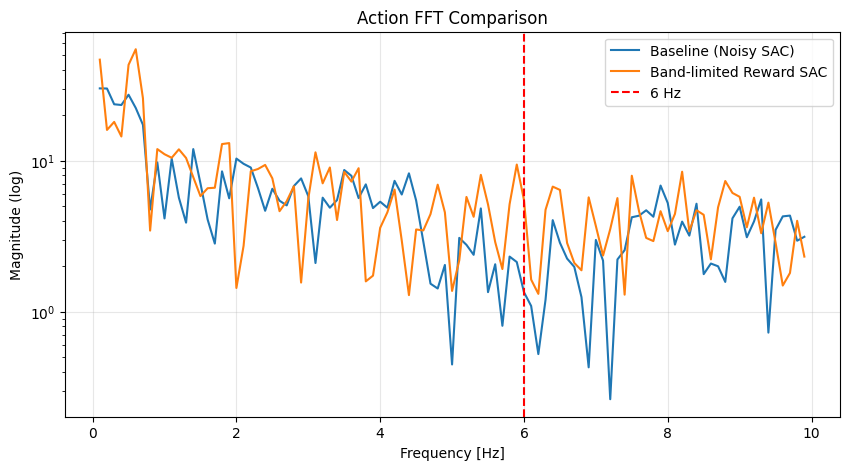

In [22]:
plt.figure(figsize=(10, 5))
plt.semilogy(freqs[mask], np.abs(fft_u_b[mask]), label="Baseline (Noisy SAC)")
plt.semilogy(freqs[mask], np.abs(fft_u_s[mask]), label="Band-limited Reward SAC")
plt.axvline(6.0, color="r", linestyle="--", label="6 Hz")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude (log)")
plt.title("Action FFT Comparison")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


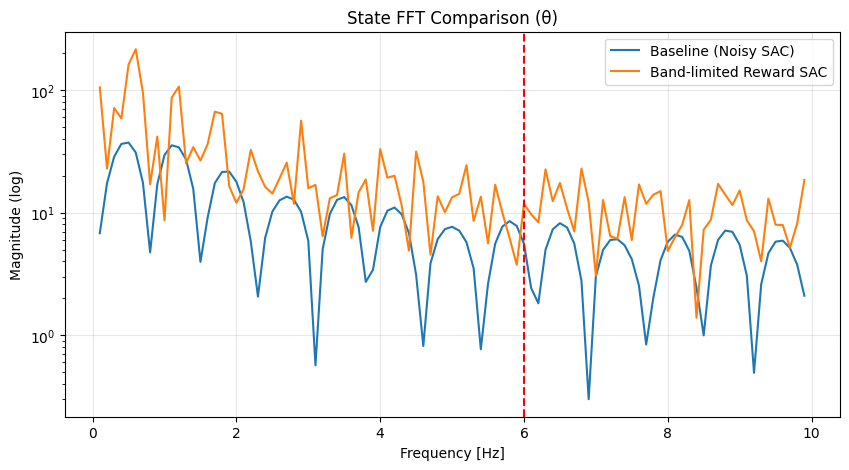

In [23]:
plt.figure(figsize=(10, 5))
plt.semilogy(freqs[mask], np.abs(fft_th_b[mask]), label="Baseline (Noisy SAC)")
plt.semilogy(freqs[mask], np.abs(fft_th_s[mask]), label="Band-limited Reward SAC")
plt.axvline(6.0, color="r", linestyle="--")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude (log)")
plt.title("State FFT Comparison (θ)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
